In [1]:
!pip install shap

In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import LabelEncoder


Shape of shap_values for input 0: (1000, 641, 1, 4)
Shape of shap_values for input 1: (1000, 3150, 1, 4)
Shape of shap_values for input 2: (1000, 641, 1, 4)


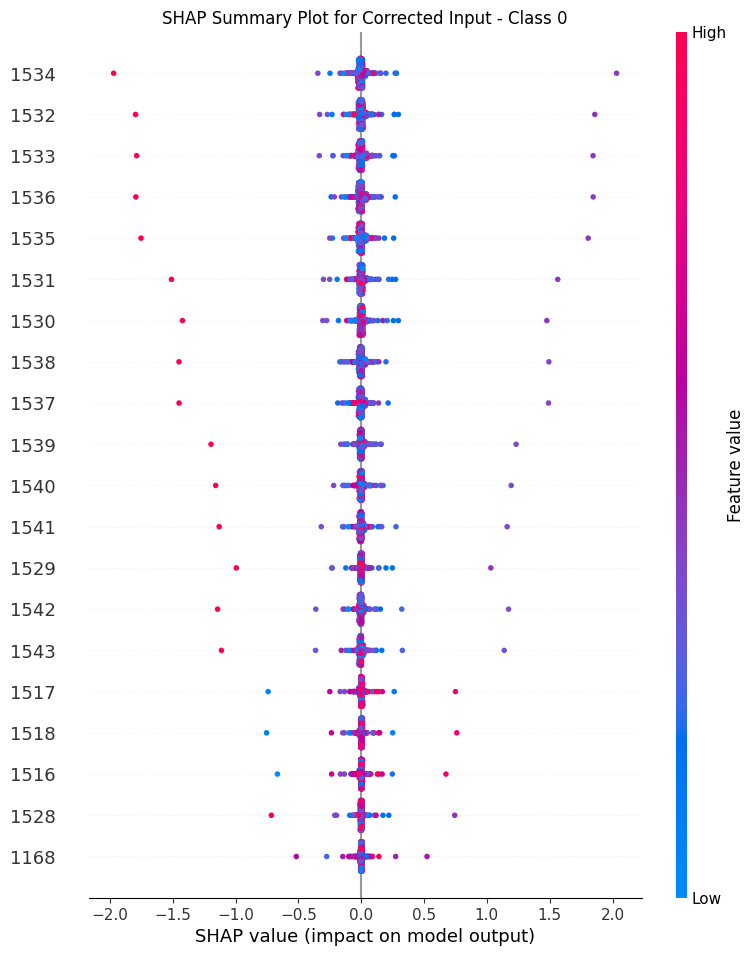

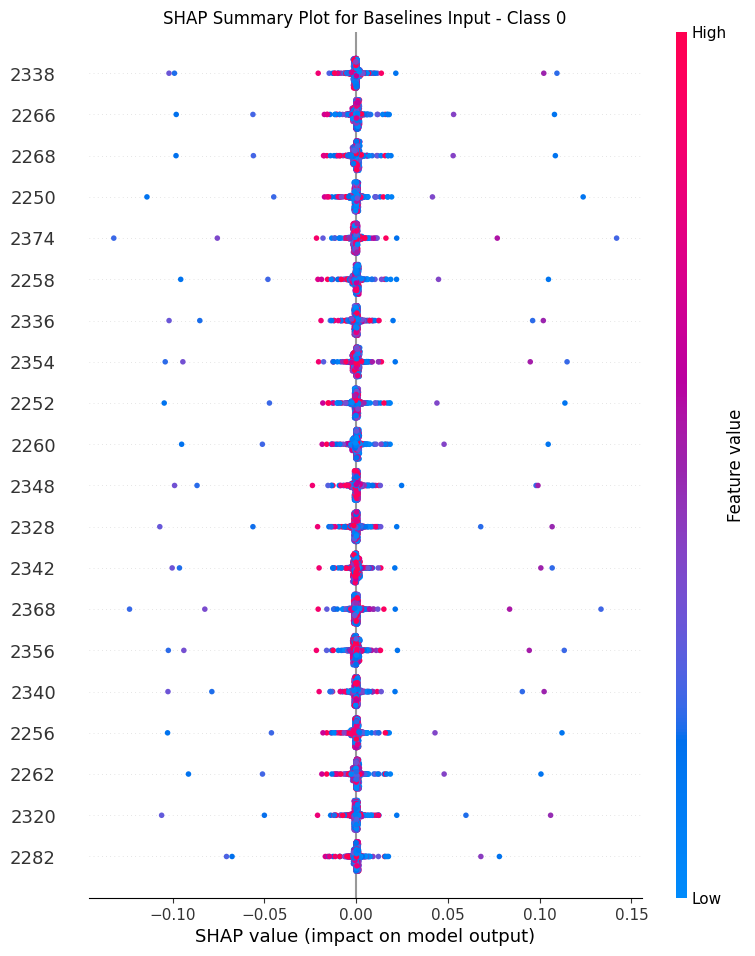

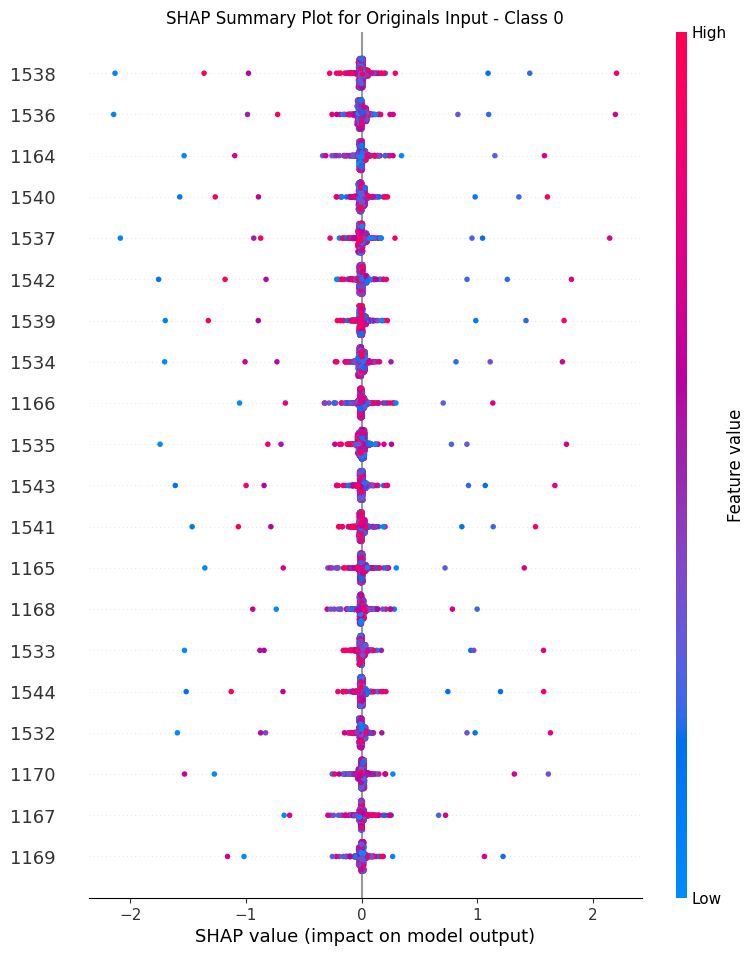

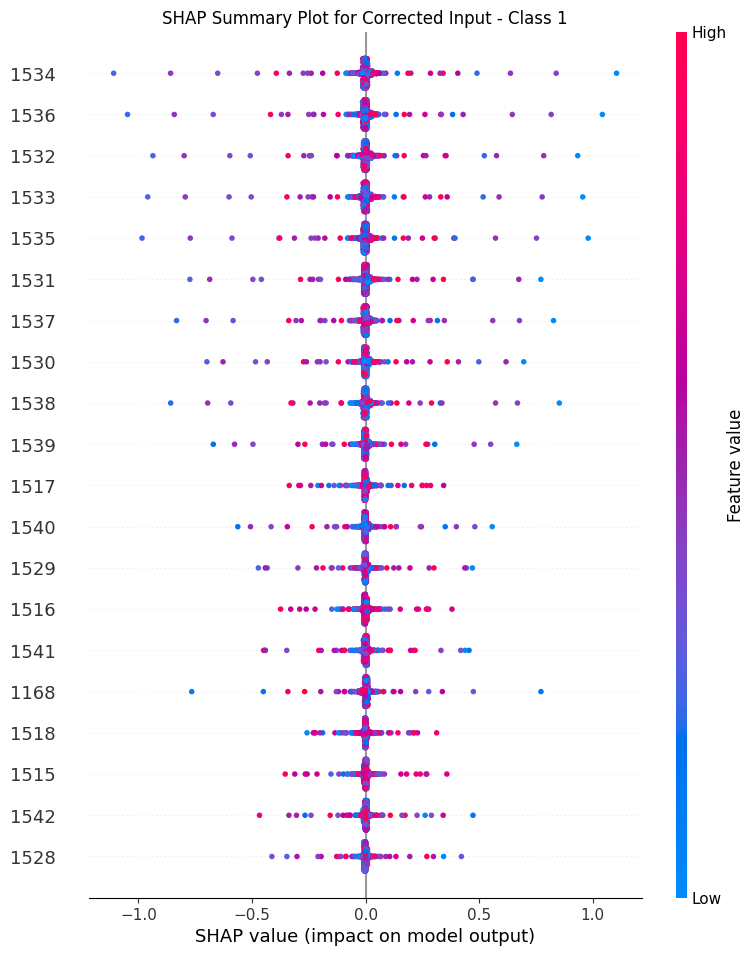

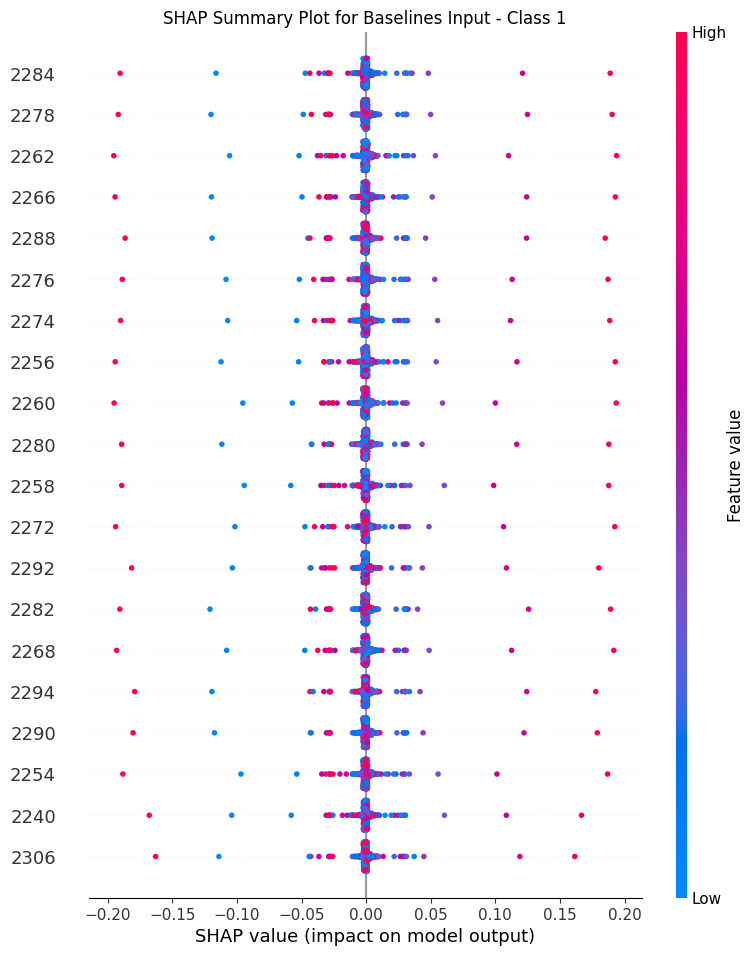

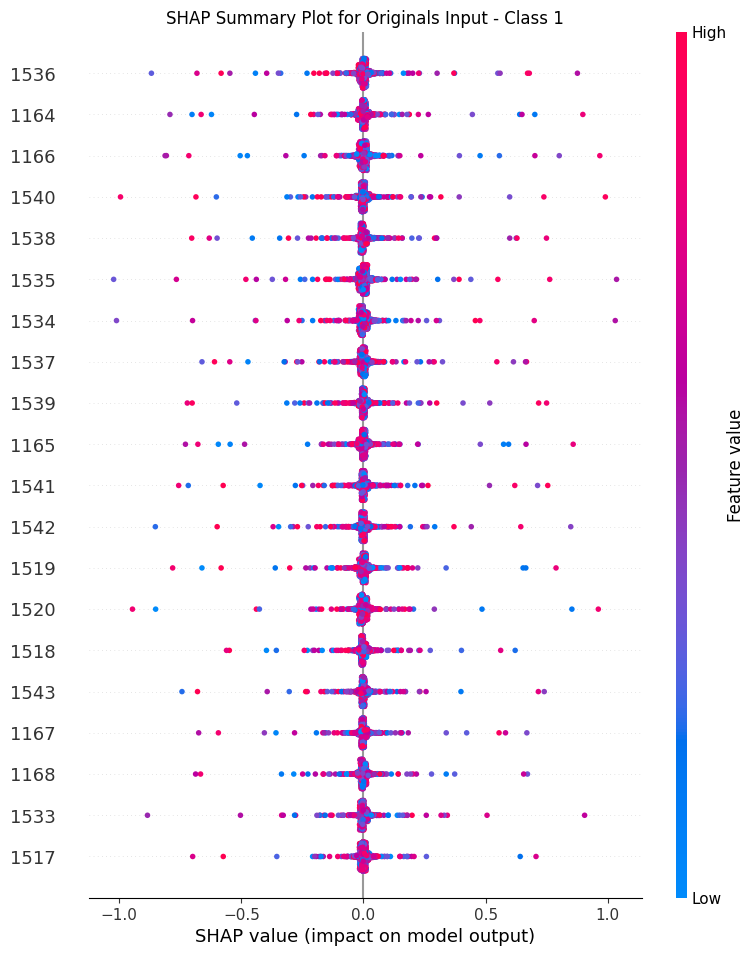

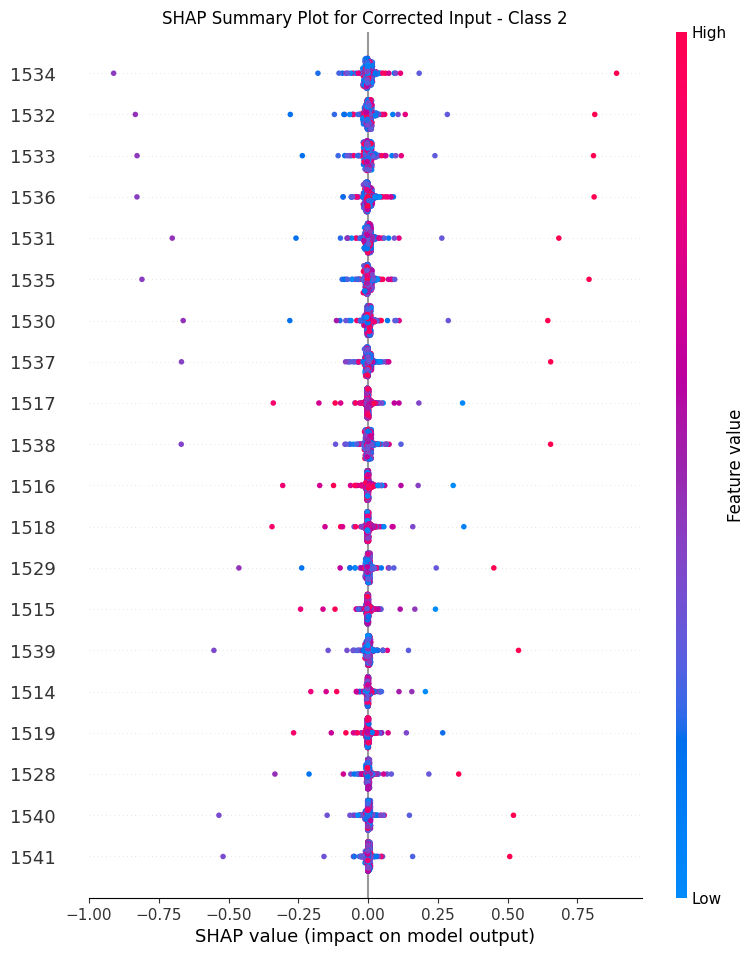

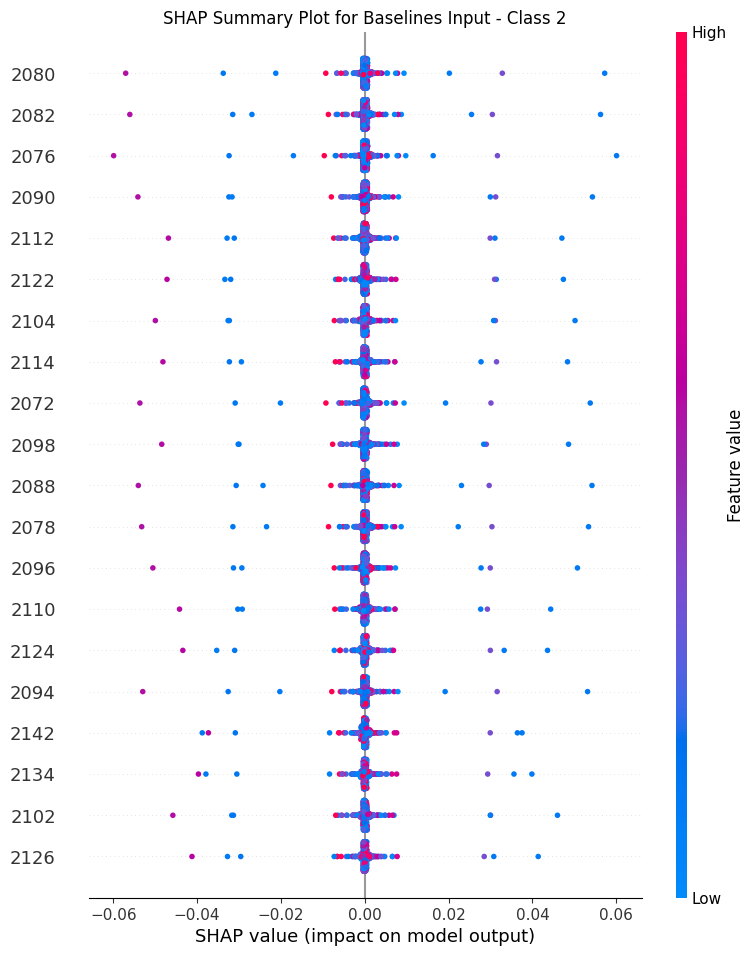

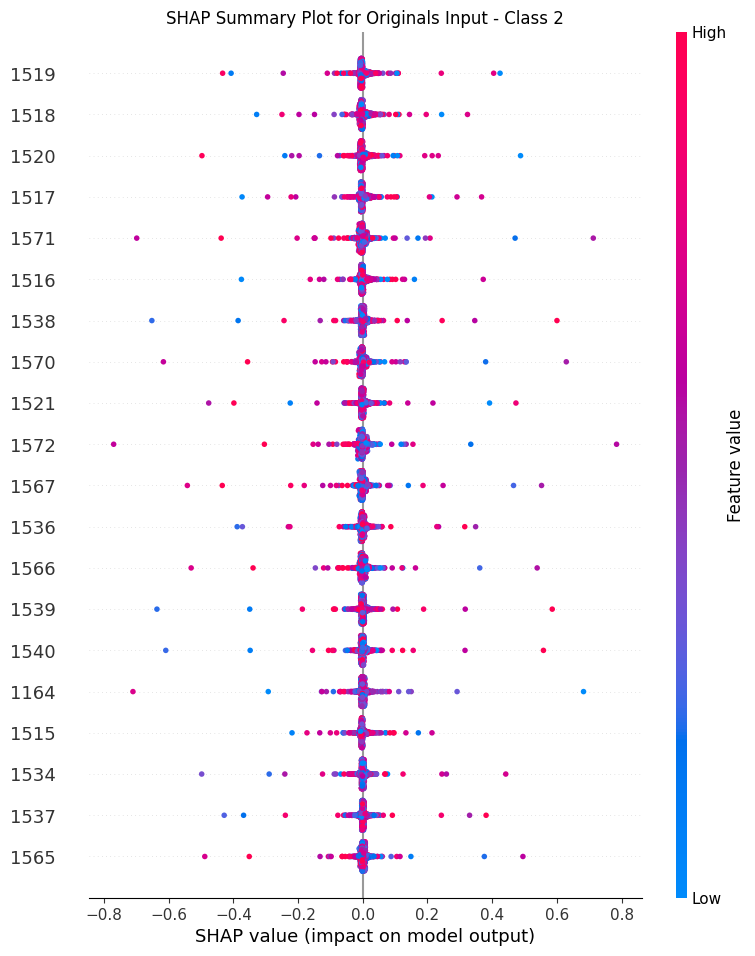

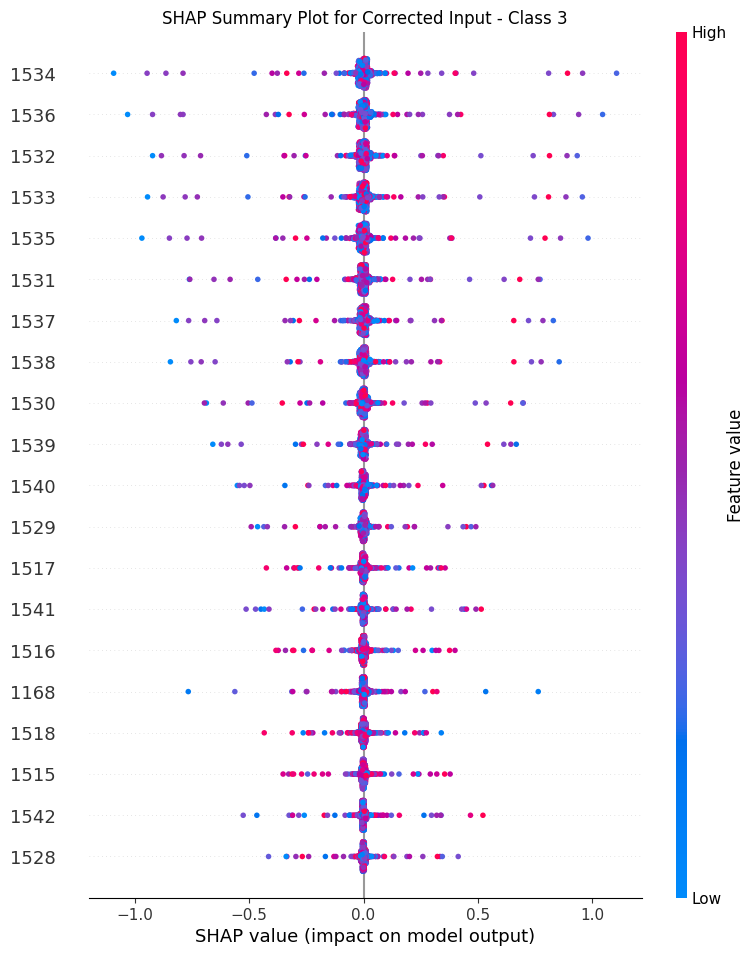

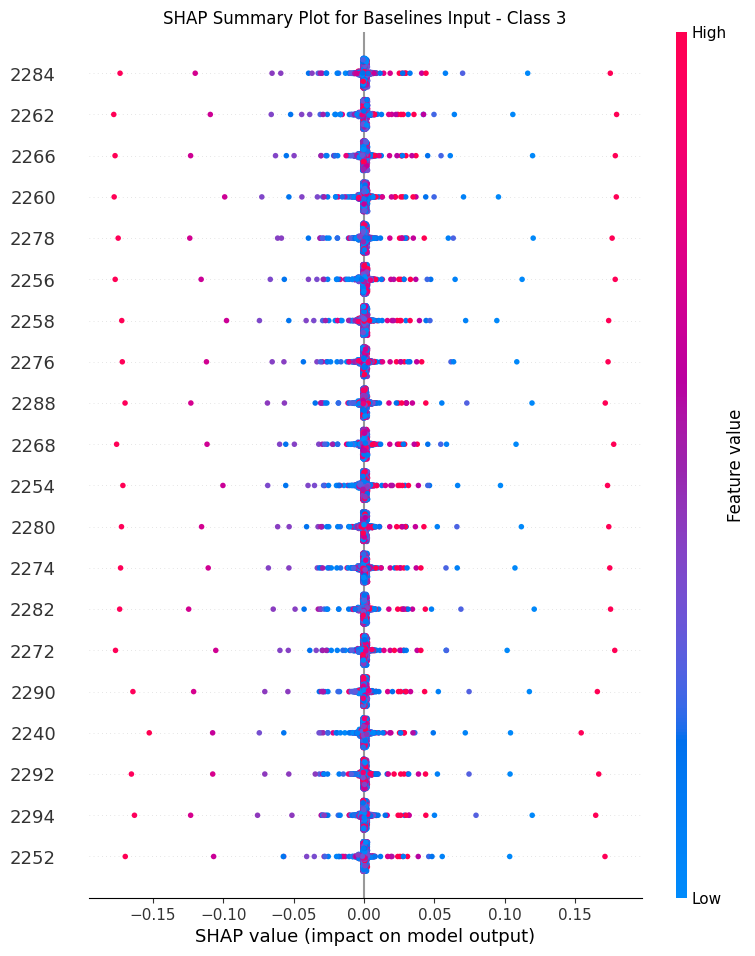

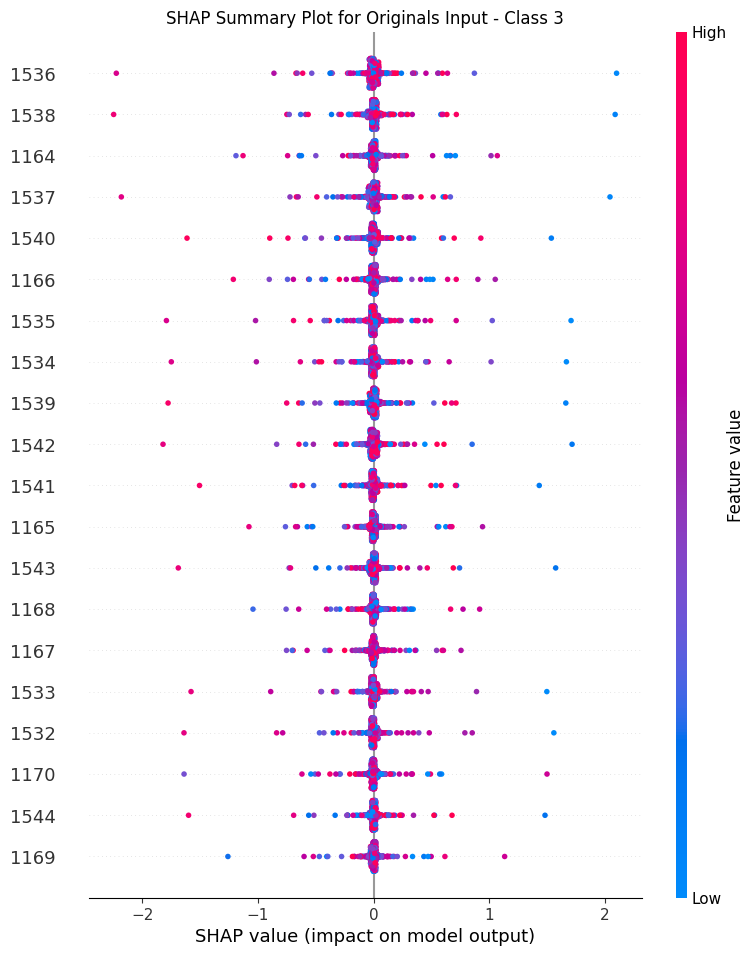

In [3]:
# Paths to your model and data files
model_path = r"C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\trained_models\definitivo\multichannel_model_simple_WITHOUTOUTLIERS_V291124_2_percentilesmahalanobis_5\model_backup.h5"

base_path = r"C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados"

ruta_csv_corrected_test = os.path.join(base_path, "especiesUAM_UNSEENS_CORRECTED_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv")
ruta_csv_baselines_test = os.path.join(base_path, "especiesUAM_UNSEENS_BASELINES_normSPECTRUM_SNR30_V171124_FILTRADOPLASTICO2percent_withCOORDINATES_WITHOUTOUTLIERS_percentile_281124.csv")
ruta_csv_originals_test = os.path.join(base_path, "RAW_CyanobacteriaSpecies_RamanSpectra_UNSEENS.csv")

# Load your pre-trained multi-channel model
model = tf.keras.models.load_model(model_path)

# Read the test data CSV files
corrected_data_test = pd.read_csv(ruta_csv_corrected_test)
baselines_data_test = pd.read_csv(ruta_csv_baselines_test)
originals_data_test = pd.read_csv(ruta_csv_originals_test)

# Verificar que los tres conjuntos tengan el mismo número de filas
assert corrected_data_test.shape[0] == baselines_data_test.shape[0] == originals_data_test.shape[0], "Los datasets no tienen el mismo número de filas"

# Generar un índice aleatorio basado en las filas de uno de los conjuntos de datos
random_indices = np.random.permutation(corrected_data_test.index)

# Aplicar el índice aleatorizado a los tres conjuntos de datos
corrected_data_test = corrected_data_test.iloc[random_indices].reset_index(drop=True)
baselines_data_test = baselines_data_test.iloc[random_indices].reset_index(drop=True)
originals_data_test = originals_data_test.iloc[random_indices].reset_index(drop=True)

# List of categorical columns to drop
categorical_columns = ['X', 'Y', 'name', 't_exp', 'date', 'medium']

# Drop categorical columns
corrected_data_test = corrected_data_test.drop(columns=categorical_columns)
baselines_data_test = baselines_data_test.drop(columns=categorical_columns)
originals_data_test = originals_data_test.drop(columns=categorical_columns)

# Specify the target column
target_column = 'especie'

# Separate features and labels
X_test_corrected = corrected_data_test.drop(columns=[target_column])
X_test_baselines = baselines_data_test.drop(columns=[target_column])
X_test_originals = originals_data_test.drop(columns=[target_column])
y_test = corrected_data_test[target_column]

# Reshape the test data inputs
X_test_corrected_reshaped = np.expand_dims(X_test_corrected.values, axis=-1)
X_test_baselines_reshaped = np.expand_dims(X_test_baselines.values, axis=-1)
X_test_originals_reshaped = np.expand_dims(X_test_originals.values, axis=-1)

# Combine inputs into a list
test_inputs = [X_test_corrected_reshaped, X_test_baselines_reshaped, X_test_originals_reshaped]


'''# Use DeepExplainer
explainer = shap.DeepExplainer(model, test_inputs_sample)
# Compute SHAP values
shap_values = explainer.shap_values(test_inputs_sample)
'''


# load SHAP values
shap_values_path = r"C:\Users\fmantecam\OneDrive - UNICAN\RamanNanoBase\FITOPLANCTON_ESPECIES_UAM\TFMjorge\df_filtrados\trained_models\shap_values_only.pkl"
with open(shap_values_path, "rb") as f:
    shap_values = pickle.load(f)

# Print shapes of shap_values
for i, shap_value in enumerate(shap_values):
    print(f"Shape of shap_values for input {i}: {shap_value.shape}")

# Get number of classes
num_classes = shap_values[0].shape[3]

# Feature names for each input
feature_names_corrected = X_test_corrected.columns.tolist()
feature_names_baselines = X_test_baselines.columns.tolist()
feature_names_originals = X_test_originals.columns.tolist()

# Loop over inputs and classes
for class_idx in range(num_classes):
    for input_idx in range(len(test_inputs)):
        # Get SHAP values for input
        shap_values_input = shap_values[input_idx]  # Shape: (num_samples, num_features, 1, num_classes)

        # Squeeze the singleton dimension
        shap_values_input = np.squeeze(shap_values_input, axis=2)  # Shape: (num_samples, num_features, num_classes)

        # Get SHAP values for the specific class
        shap_values_input_class = shap_values_input[:, :, class_idx]  # Shape: (num_samples, num_features)

        # Get feature names and data
        if input_idx == 0:
            features = X_test_corrected.iloc[:shap_values_input_class.shape[0]]
            feature_names = feature_names_corrected
            input_name = 'Corrected'
        elif input_idx == 1:
            features = X_test_baselines.iloc[:shap_values_input_class.shape[0]]
            feature_names = feature_names_baselines
            input_name = 'Baselines'
        else:
            features = X_test_originals.iloc[:shap_values_input_class.shape[0]]
            feature_names = feature_names_originals
            input_name = 'Originals'

        # Convert feature_names to NumPy array
        feature_names = np.array(feature_names)

        # Plot summary
        shap.summary_plot(
            shap_values_input_class,
            features=features,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP Summary Plot for {input_name} Input - Class {class_idx}")
        plt.show()


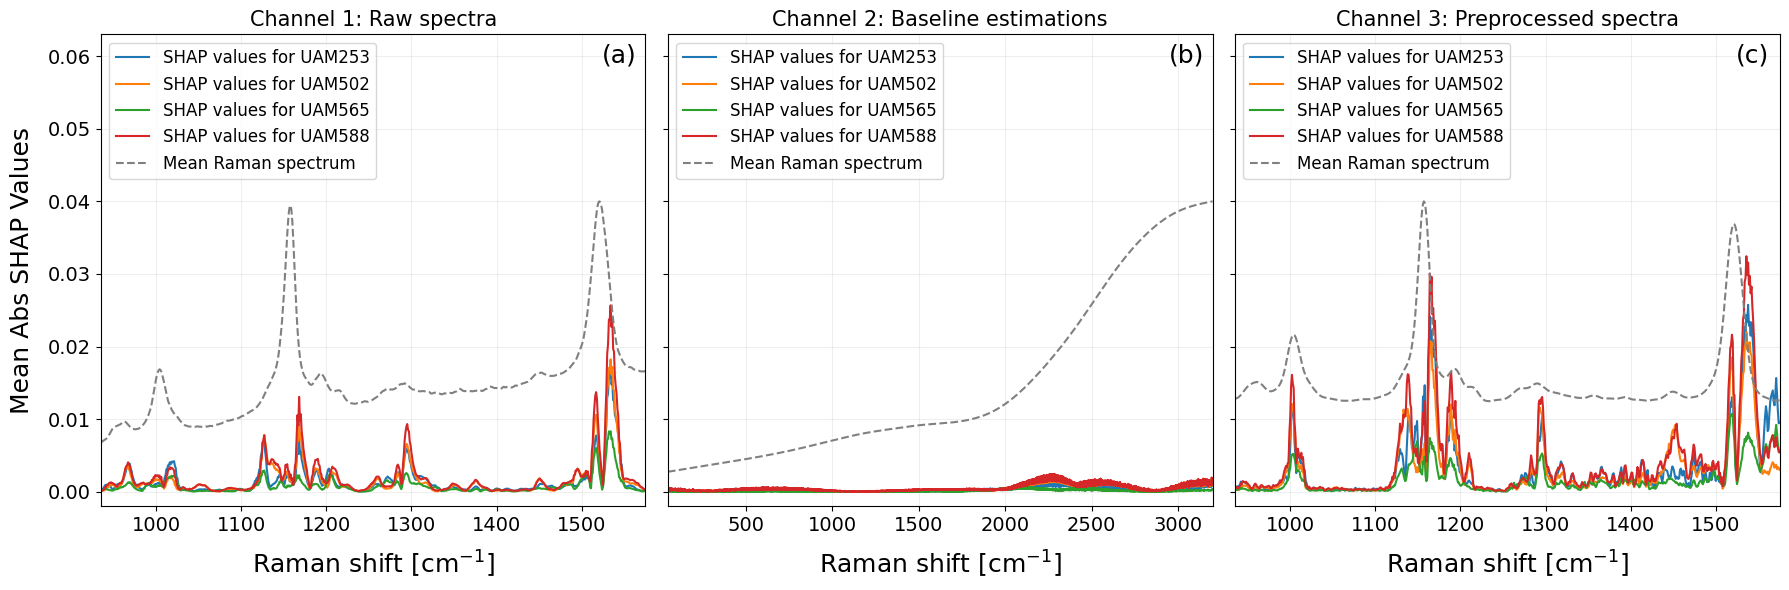

In [41]:

# Calculation of unnormalized means
mean_corrected = np.mean(corrected_data_test.iloc[:, :-1], axis=0)
mean_baselines = np.mean(baselines_data_test.iloc[:, :-1], axis=0)
mean_originals = np.mean(originals_data_test.iloc[:, :-1], axis=0)

# Define Raman shifts based on the type of data
ramanshifts_corrected = np.arange(935, 1576, 1)
ramanshifts_originals = np.arange(935, 1576, 1)
ramanshifts_baselines = np.arange(50, 3200, 1)

# Get the real class names from the labels
le = LabelEncoder()
le.fit(y_test)  # Fit the LabelEncoder to the labels in y_test
class_names = le.classes_  # Get the class names

# Configuration for subplots
datasets = ['Raw spectra', 'Baseline estimations', 'Preprocessed spectra']
ramanshifts_list = [ramanshifts_originals, ramanshifts_baselines, ramanshifts_corrected]
shap_values_list = shap_values  # SHAP values generated earlier
colors = ['C0', 'C1', 'C2', 'C3']  # Colors for each class

# Fixed SHAP colors
colors_shap = ['C0', 'C1', 'C2', 'C3']

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.patch.set_facecolor('white')


# Define mean_list with normalized means for each dataset
mean_list = [
    mean_originals / np.max(mean_originals),  # Normalize mean_originals
    mean_baselines / np.max(mean_baselines),  # Normalize mean_baselines
    mean_corrected / np.max(mean_corrected)   # Normalize mean_corrected
]


labels = ['(a)', '(b)', '(c)']


for i, (dataset, ramanshifts, shap_values_input, normalized_mean) in enumerate(zip(datasets, ramanshifts_list, shap_values_list, mean_list)):
    
    # Remove the singleton dimension using np.squeeze()
    shap_values_input_squeezed = np.squeeze(shap_values_input)  # Convert from (30, 641, 1, 4) to (30, 641, 4)
    
    # Extract SHAP values (absolute value) for the classes
    values_class0 = np.mean(np.abs(shap_values_input_squeezed[:, :, 0]), axis=0)
    values_class1 = np.mean(np.abs(shap_values_input_squeezed[:, :, 1]), axis=0)
    values_class2 = np.mean(np.abs(shap_values_input_squeezed[:, :, 2]), axis=0)
    values_class3 = np.mean(np.abs(shap_values_input_squeezed[:, :, 3]), axis=0)
    
    # Plot in the corresponding subplot
    axs[i].plot(ramanshifts, values_class0, label=f"SHAP values for {class_names[0]}", color='C0')
    axs[i].plot(ramanshifts, values_class1, label=f"SHAP values for {class_names[1]}", color='C1')
    axs[i].plot(ramanshifts, values_class2, label=f"SHAP values for {class_names[2]}", color='C2')
    axs[i].plot(ramanshifts, values_class3, label=f"SHAP values for {class_names[3]}", color='C3')
    
    # Add the dashed grey line with the dataset mean
    axs[i].plot(ramanshifts, normalized_mean / 40 + 0.015, linestyle='--', color='grey', label='Mean Raman spectrum')
    
    # Dynamic title for each subplot
    axs[i].set_title(f"Channel {i+1}: {dataset}", fontsize=15)
    axs[i].set_xlabel('Raman shift [cm$^{-1}$]', fontsize=18, labelpad=10)
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    axs[i].set_ylabel('Mean Abs SHAP Values' if i == 0 else '', fontsize = 18, labelpad=10)  # Only the first subplot will have a Y-axis label
    axs[i].legend(loc='upper left', fontsize=12)
    axs[i].grid(alpha=0.2)
    axs[i].set_xlim(ramanshifts[0], ramanshifts[-1])
    axs[i].set_ylim(-0.002, 0.063)
    axs[i].text(0.92, 0.98, labels[i], transform=axs[i].transAxes, fontsize=18, verticalalignment='top')

# Adjust layout
plt.tight_layout()
#fig.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\fig7_SHAP_values.svg', format='svg', bbox_inches='tight', dpi = 300)
#fig.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\fig7_SHAP_values.png', format='png', bbox_inches='tight', dpi = 300)
plt.show()


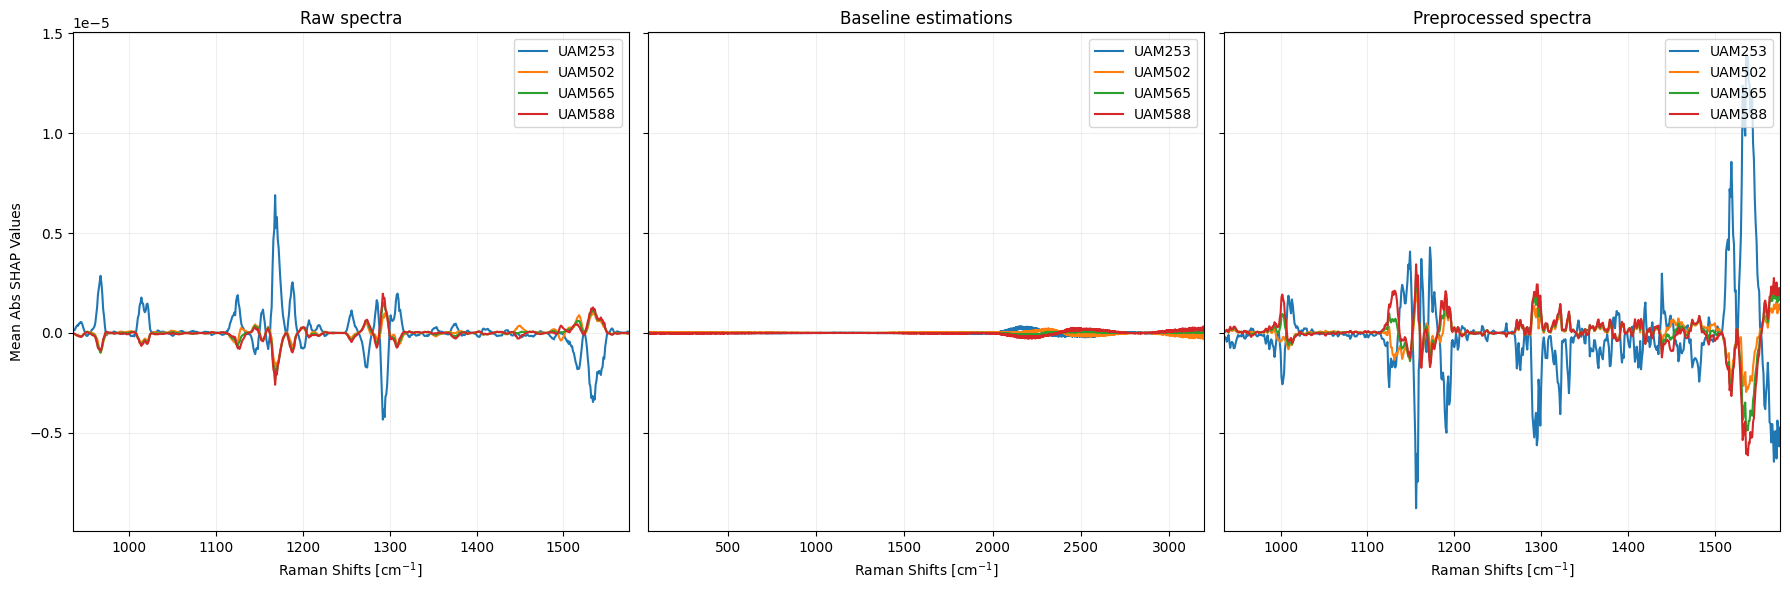

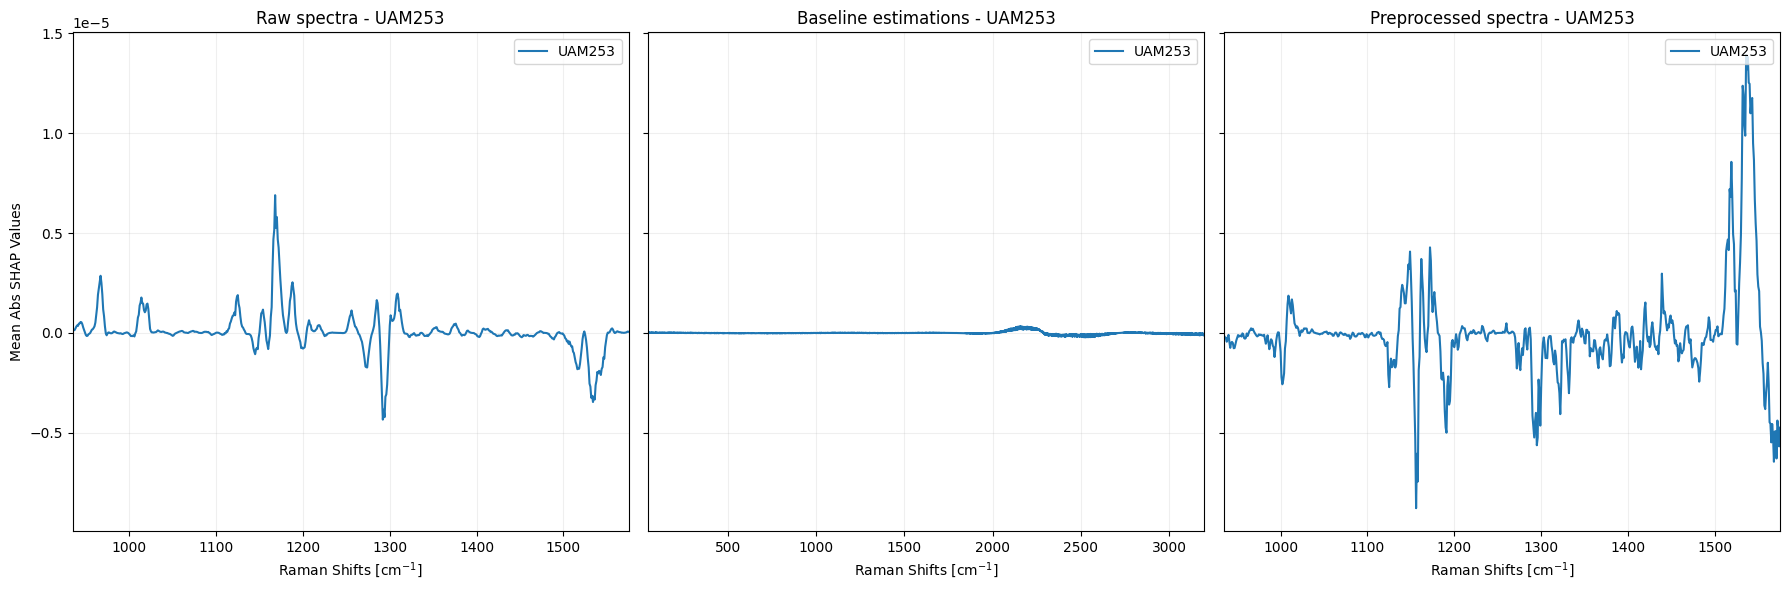

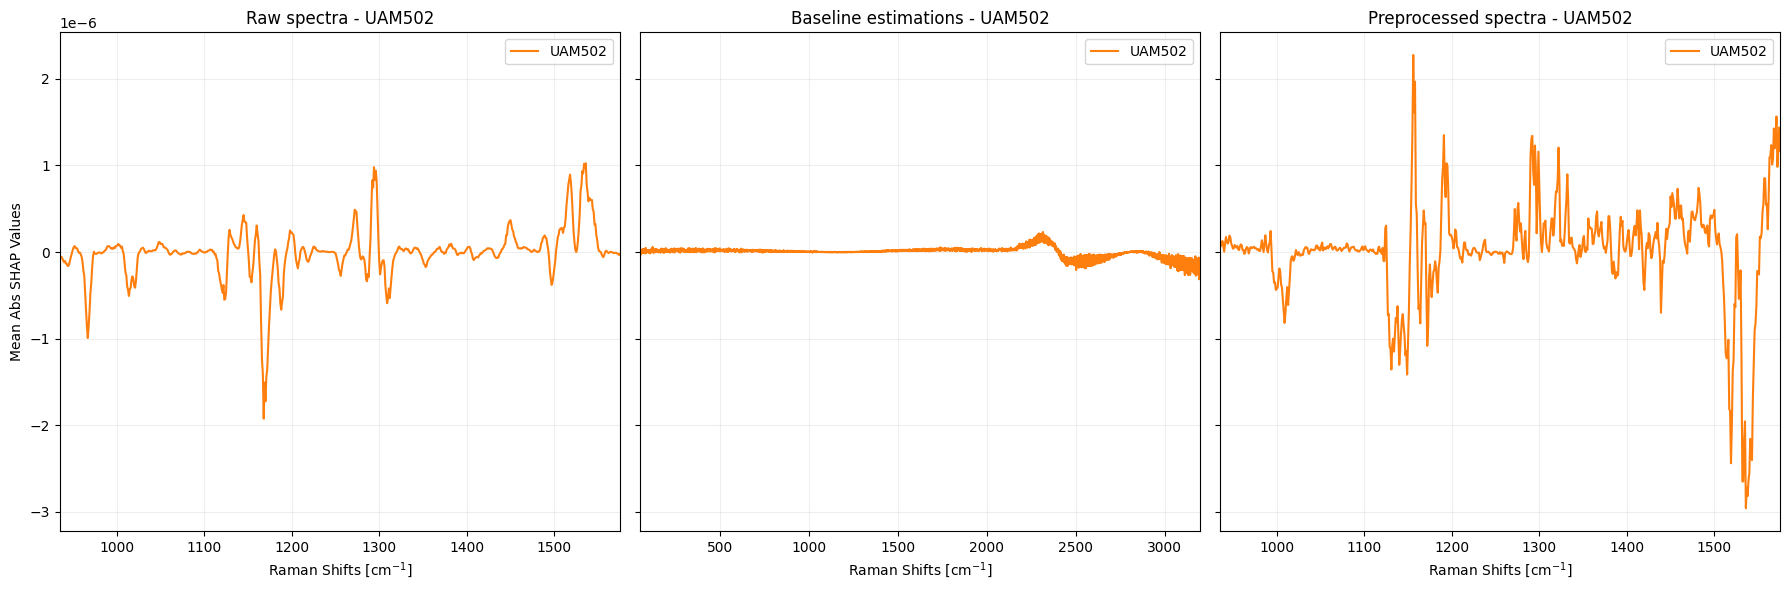

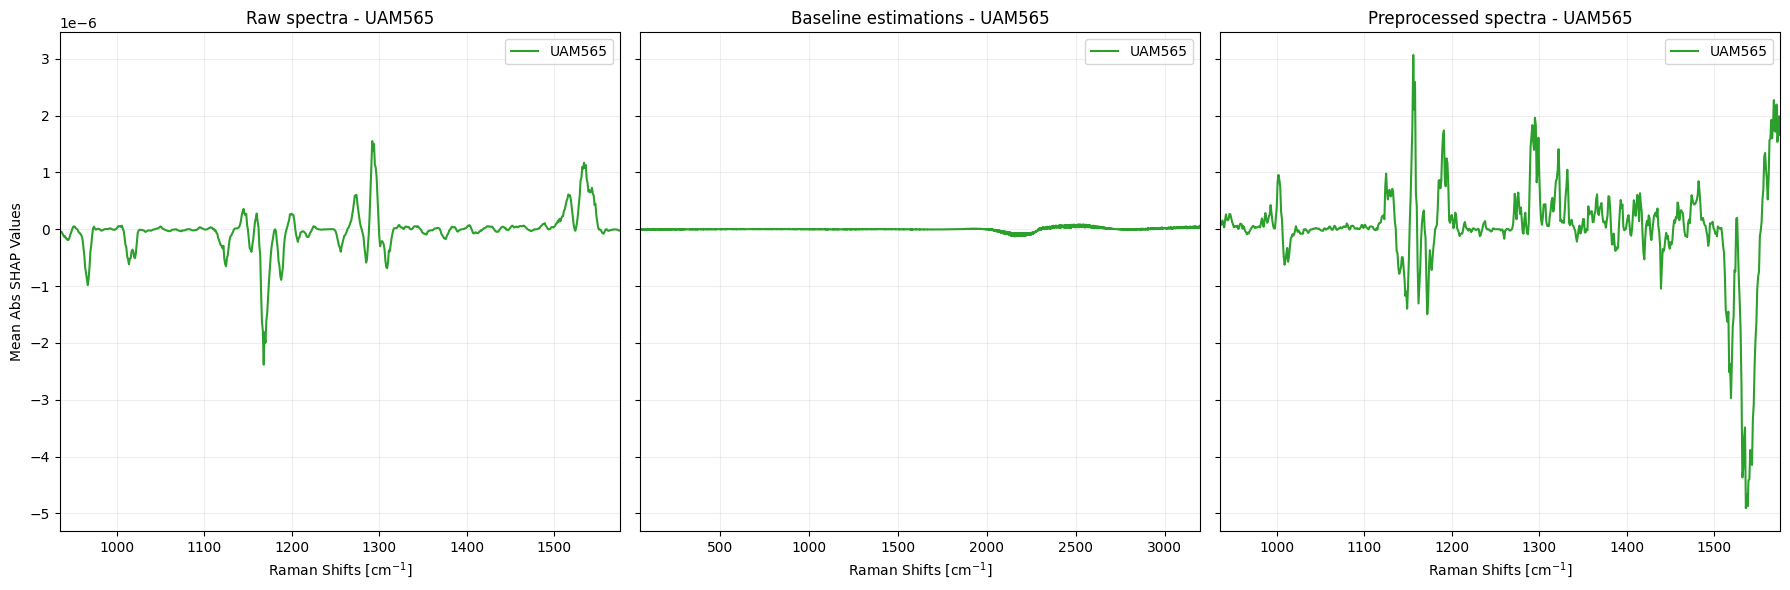

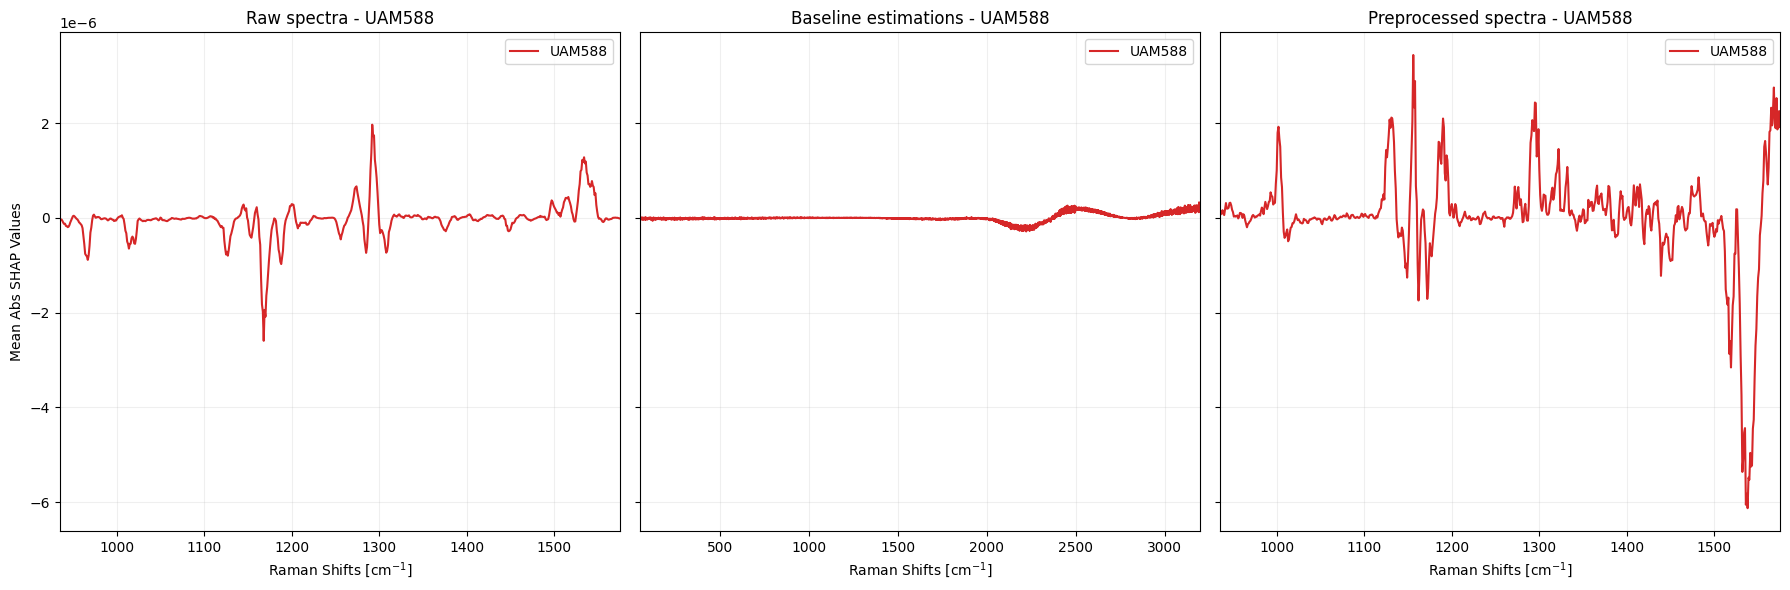

Top SHAP values for Raw spectra - UAM253:
     Feature  SHAP Value
599     1534    0.016912
597     1532    0.015960
598     1533    0.015752
601     1536    0.015244
600     1535    0.014799
596     1531    0.013533
595     1530    0.013004
603     1538    0.012710
602     1537    0.012616
604     1539    0.010609
Top SHAP values for Raw spectra - UAM502:
     Feature  SHAP Value
599     1534    0.018235
601     1536    0.017185
597     1532    0.017037
598     1533    0.016998
600     1535    0.016156
596     1531    0.014837
602     1537    0.014207
595     1530    0.014026
603     1538    0.013945
604     1539    0.011510
Top SHAP values for Raw spectra - UAM565:
     Feature  SHAP Value
599     1534    0.008342
597     1532    0.008332
598     1533    0.008016
601     1536    0.007351
596     1531    0.007317
600     1535    0.007249
595     1530    0.007178
602     1537    0.006090
582     1517    0.006035
603     1538    0.006013
Top SHAP values for Raw spectra - UAM588:
     Fe

In [36]:

# 1. Plot SHAP values combined for all classes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.patch.set_facecolor('white')

# Iterate through datasets and create subplots
for i, (dataset, ramanshifts, shap_values_input) in enumerate(zip(datasets, ramanshifts_list, shap_values_list)):
    # Remove the singleton dimension using np.squeeze()
    shap_values_input_squeezed = np.squeeze(shap_values_input)  # From (30, 641, 1, 4) to (30, 641, 4)

    # Extract SHAP values for each class
    values_class0 = np.mean(shap_values_input_squeezed[:, :, 0], axis=0)
    values_class1 = np.mean(shap_values_input_squeezed[:, :, 1], axis=0)
    values_class2 = np.mean(shap_values_input_squeezed[:, :, 2], axis=0)
    values_class3 = np.mean(shap_values_input_squeezed[:, :, 3], axis=0)

    # Plot SHAP values in the corresponding subplot
    axs[i].plot(ramanshifts, values_class0, label=class_names[0], color=colors[0])
    axs[i].plot(ramanshifts, values_class1, label=class_names[1], color=colors[1])
    axs[i].plot(ramanshifts, values_class2, label=class_names[2], color=colors[2])
    axs[i].plot(ramanshifts, values_class3, label=class_names[3], color=colors[3])

    axs[i].set_title(f"{dataset}")
    axs[i].set_xlabel('Raman Shifts [cm$^{-1}$]')
    axs[i].set_ylabel('Mean Abs SHAP Values' if i == 0 else '')  # Only the first subplot will have a Y-axis label
    axs[i].legend(loc='upper right')
    axs[i].grid(alpha=0.2)
    axs[i].set_xlim(ramanshifts[0], ramanshifts[-1])

# Adjust layout
plt.tight_layout()
plt.show()

# 2. Plot SHAP values individually for each class
for class_idx, class_name in enumerate(class_names):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.patch.set_facecolor('white')

    for i, (dataset, ramanshifts, shap_values_input) in enumerate(zip(datasets, ramanshifts_list, shap_values_list)):
        shap_values_input_squeezed = np.squeeze(shap_values_input)  # From (30, 641, 1, 4) to (30, 641, 4)
        shap_values_class = np.mean(shap_values_input_squeezed[:, :, class_idx], axis=0)

        # Plot SHAP values for the current class
        axs[i].plot(ramanshifts, shap_values_class, label=class_name, color=colors[class_idx])
        axs[i].set_title(f"{dataset} - {class_name}")
        axs[i].set_xlabel('Raman Shifts [cm$^{-1}$]')
        axs[i].set_ylabel('Mean Abs SHAP Values' if i == 0 else '')  # Only the first subplot will have a Y-axis label
        axs[i].legend(loc='upper right')
        axs[i].grid(alpha=0.2)
        axs[i].set_xlim(ramanshifts[0], ramanshifts[-1])

    plt.tight_layout()
    plt.show()

# 3. Create DataFrames with the most important SHAP values per class and dataset
df_dict = {}
for i, (dataset, ramanshifts, shap_values_input) in enumerate(zip(datasets, ramanshifts_list, shap_values_list)):
    shap_values_input_squeezed = np.squeeze(shap_values_input)  # From (30, 641, 1, 4) to (30, 641, 4)

    # Create an empty list to store DataFrames for each class
    dfs = []

    for class_idx, class_name in enumerate(class_names):
        shap_values_class = np.mean(np.abs(shap_values_input_squeezed[:, :, class_idx]), axis=0)  # Take absolute values and mean
        df_class = pd.DataFrame({
            'Feature': ramanshifts,
            'SHAP Value': shap_values_class
        }).sort_values(by='SHAP Value', ascending=False)

        # Add the DataFrame to the dictionary for this dataset and class
        dfs.append(df_class)

        print(f"Top SHAP values for {dataset} - {class_name}:")
        print(df_class.head(10))  # Print the top 10 most important features for each class

    # Save DataFrames in a dictionary with the dataset name
    df_dict[dataset] = dfs


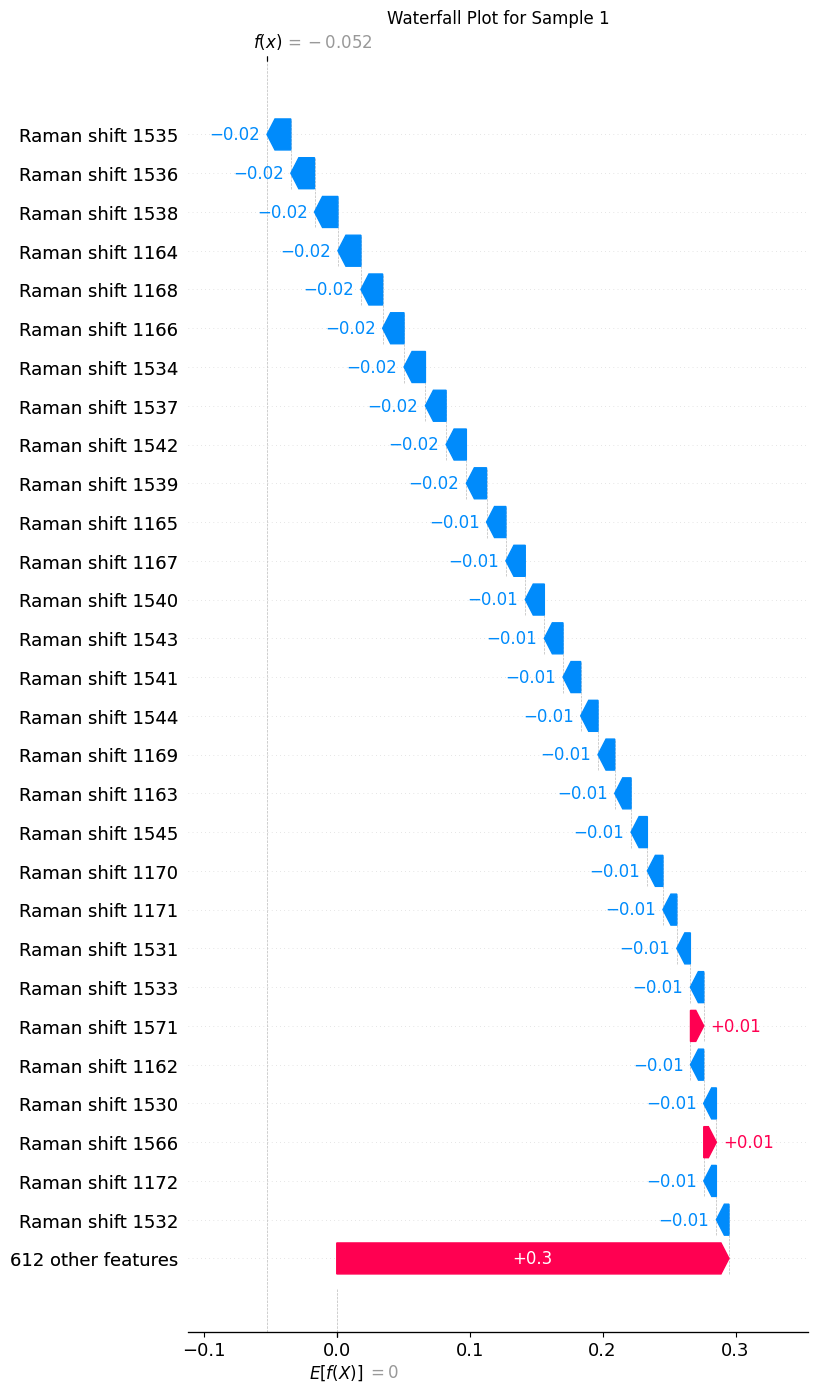

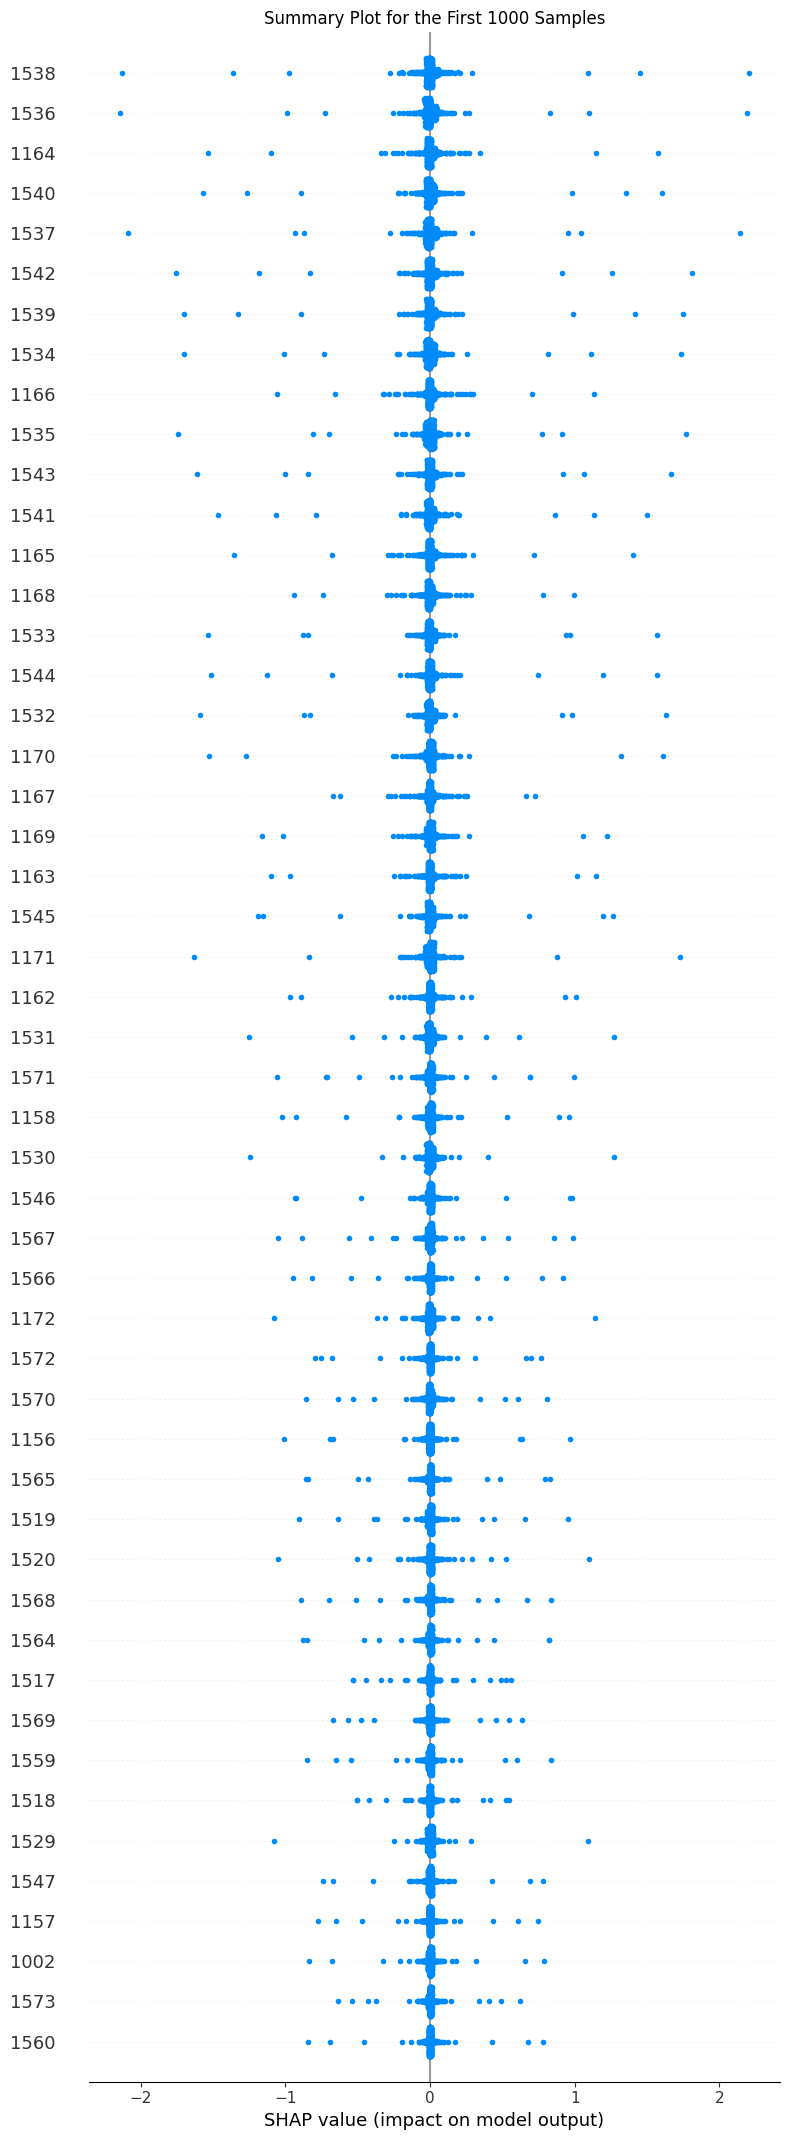

In [37]:

# Select multiple samples (e.g., the first 1000) for class 0 in the "Corrected" dataset
num_samples = 1000  # Number of samples to visualize
shap_values_corrected = np.squeeze(shap_values[2])  # SHAP values for the "Corrected" dataset
shap_values_class_0 = shap_values_corrected[:, :, 0]  # SHAP values for class 0

# Select the first `num_samples` spectra
shap_values_samples = shap_values_class_0[:num_samples]

# Verify dimensions match between SHAP values and Raman shifts
if shap_values_samples.shape[1] != len(ramanshifts_corrected):
    raise ValueError(f"Dimensions mismatch: SHAP values {shap_values_samples.shape[1]} vs Raman shifts {len(ramanshifts_corrected)}")

# === Waterfall Plot for the First Spectrum ===
# Select the first sample for the waterfall plot
shap_values_example = shap_values_samples[0]  # First spectrum

# Create the SHAP 'Explanation' structure
explainer_values = shap.Explanation(
    values=shap_values_example,
    feature_names=[f"Raman shift {shift}" for shift in ramanshifts_corrected],
    base_values=0  # Placeholder base value
)

# Visualize the explanation as a waterfall plot
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
plt.title('Waterfall Plot for Sample 1')

# Generate the waterfall plot
shap.waterfall_plot(explainer_values, max_display=30)
plt.show()

# Close the figure to prevent accumulation
plt.close(fig)

# === Summary Plot for 100 Samples ===
# SHAP summary plot for the first 1000 samples
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
plt.title(f'Summary Plot for the First {num_samples} Samples')

# Generate the SHAP summary plot for the selected samples
shap.summary_plot(
    shap_values_samples, 
    features=ramanshifts_corrected, 
    max_display=50
)

plt.show()

# Close the figure after display
plt.close(fig)

